<h1><center>Защита данных клиентов страховой компании</center></h1>

Страховой компании «Хоть потоп» необходимо защитить данные своих клиентов. Это требуется сделать таким образом, чтобы при преобразовании данных качество моделей машинного обучения не ухудшилось. 

**Цель работы** – разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию.

**Основные этапы:**
1. [Загрузка данных](#Загрузка-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Разработка и доказательство пригодности способа шифрования](#Алгоритм-преобразования)
4. [Проверка](#Проверка-алгоритма)
5. [Вывод](#Вывод)

## Импорт необходимых модулей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Загрузка данных

In [2]:
data = pd.read_csv(r'C:/Users/dcba5/Python_Jupyter_files/Data/insurance.csv')

In [3]:
# обзор данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
# первый взгляд на данные

data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


## Предобработка данных

In [5]:
# изменение названий признаков для удобства

data.rename(columns={'Пол': 'sex',
                     'Возраст': 'age',
                     'Зарплата': 'salary',
                     'Члены семьи': 'relatives',
                     'Страховые выплаты': 'insurance'},
            inplace=True)

In [6]:
# обнаружение явных дубликатов

data.duplicated().sum()

153

In [7]:
# удаление дубликатов
data.drop_duplicates(inplace=True)

# сброс индексов
data.reset_index(drop=True)

,sex,age,salary,relatives,insurance
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4842,0,28.0,35700.0,2,0
4843,0,34.0,52400.0,1,0
4844,0,20.0,33900.0,2,0
4845,1,22.0,32700.0,3,0


Признаков немного, воспользуемся функцией seaborn pairplot для визуализации распределений величин и их парной взаимозависимости.

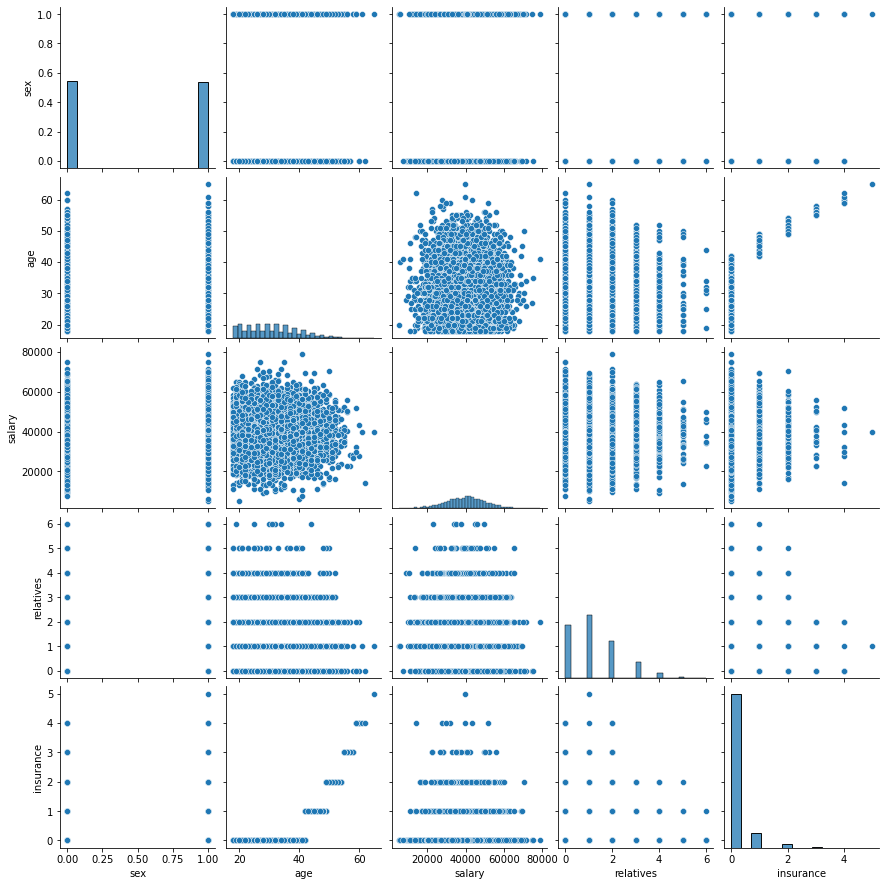

In [8]:
sns.pairplot(data)

Существенных аномалий в распределении признаков обнаружено не было. Некоторые признаки имеют корреляцию.

<AxesSubplot:ylabel='insurance'>

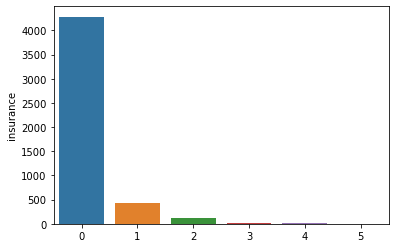

In [29]:
sns.barplot(x=data['insurance'].value_counts().index, y=data['insurance'].value_counts())

<AxesSubplot:ylabel='relatives'>

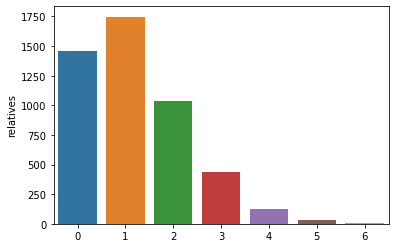

In [30]:
sns.barplot(x=data['relatives'].value_counts().index, y=data['relatives'].value_counts())

## Алгоритм преобразования

**Алгоритм**

1. Выделение из данных матрицы с признаками (без целевого)
2. Масштабирование признаков
3. Создание случайной матрицы и её проверка на обратимость
4. Умножение матрицы признаков на обратимую матрицу

<font size="5">**Докажем, что умножение матрицы признаков на случайную обратимую матрицу не исказит результат работы модели**</font>

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

<font size="5">**Доказательство**</font>

1. $ a = Xw $, найдём $ a' $ для преобразованной матрицы

   Упростим **w**: $ w = (X^T X)^{-1} X^T y => w = X^{-1} X^{T-1} X^T y $  
   Получим: $w = X^{-1} y$


2. Пусть $ X' = X \cdot P $
  
  
3. Тогда $ w = (X'^TX')^{-1}X^Ty $
  
  
4. Воспользуемся следующими свойствами: $ A^T B^T = (BA)^T $;   $ (AB)^{-1} = B^{-1}A^{-1}$ 
  
$$ w = ((XP)^T X P)^{-1}(XP)^T y $$
  
$$ w = (P^T (X^T X) P)^{-1}P^T X^T y $$
  
$$ w = P^{-1} (P^T (X^T X))^{-1} P^T X^T y $$
  
$$ w' = P^{-1} (X^T X)^{-1} P^{T-1} P^T X^T y $$
  
$$ w' = P^{-1} (X^T X)^{-1} I X^T y $$
  
$$ w' = P^{-1} X^{-1} X^{T-1} I X^T y $$
  
$$ w' = P^{-1} X^{-1} y $$

5. $ a' = X P w' $
  Упростим путём подстановки $ w' $: $a' = X P P^{-1} X^{-1} y => X I X^{-1} y = Xw $
  
Из $ a = Xw = a' $ следует, что при умножнении признаков на обратимую матрицу метрика изменится не должна.


**Вывод:** выше приведено доказательство того, что при умножении матрицы признаков на обратимую матрицу, матрица предсказаний не пострадает. Наша задача состоит в том, чтобы: 
1. создать матрицу, ширина которой равна кол-ву признаков (это условие для возможности умножения матриц)
2. проверить её на обратимость (доказательство верно для обратимых матриц)
3. умножить матрицу признаков на обратимую матрицу для шифрования 

## Проверка алгоритма

### Подготовка данных

Выделение признаков и целевого признака

In [10]:
features = data.drop('insurance', axis=1)

In [11]:
target = data.insurance

Создание компонента, масштабирующего признаки с последующим масштабированием

In [12]:
scaled_features = StandardScaler().fit_transform(features)

Подготовка шифрующей матрицы

In [13]:
# создание случайной матрицы для преобразования признаков с проверкой на обратимость

try:
    encrypting_matrix = np.random.randint(100, size=(features.shape[1], features.shape[1]))
    inverse_check = np.linalg.inv(encrypting_matrix)
except:
    encrypting_matrix = np.random.randint(100, size=(features.shape[1], features.shape[1]))

In [14]:
# проверка

encrypting_matrix

array([[51, 95, 77, 46],
       [72, 29, 56,  9],
       [36, 52,  6, 19],
       [28, 52, 52, 95]])

In [15]:
# шифрование признаков

encrypted_features = scaled_features @ encrypting_matrix

### Создание модели

In [16]:
w = (np.linalg.inv(scaled_features.T @ scaled_features) @ scaled_features.T) @ target

In [17]:
w_encrypted = (np.linalg.inv(encrypted_features.T @ encrypted_features) @ encrypted_features.T) @ target

In [18]:
a_difference = (encrypted_features @ w_encrypted) - (scaled_features @ w)

In [19]:
print(a_difference)

[-7.77156117e-16  7.10542736e-15  5.16947596e-15 ... -2.22044605e-16
  2.77555756e-16 -2.65065747e-15]


Разница пренебрежимо мала. Векторы предсказаний практически идентичны.

**Проверка будет состоять из двух этапов:** 

1. Получаем метрику R2 для признаков 
2. Сравниваем с метрикой R2 для модели обученной на преобразованных признаках

In [20]:
model = LinearRegression()

In [21]:
# модель, обученная на исходных признаках

model.fit(features, target)
preds = model.predict(features)
original_r2 = r2_score(target, preds)

print('R2 for original features: ', original_r2)

R2 for original features:  0.4302010044852068


In [22]:
model = LinearRegression()

In [23]:
# модель, обученная на зашифрованных признаках

model.fit(encrypted_features, target)
encrypted_preds = model.predict(encrypted_features)
encrypted_r2 = r2_score(target, encrypted_preds)

print('R2 for transformed features: ', encrypted_r2)

R2 for transformed features:  0.4302010044852068


In [24]:
original_r2 - encrypted_r2

0.0

Разница метрик пренебрежимо мала

## Вывод

В ходе выполнения задачи данного проекта был предложен способ шифрования данных с сопуствующим математическим обоснованием и произведена проверка его работы.